The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


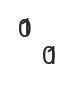

In [21]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass, NNAlignEFTwoStage
from src.datasets import NNAlignDataset

In [10]:
no_struct = pd.concat([pd.read_csv(x)[['sequence','target','HLA','fold','protein_id','start_position','end_position','len','pred','core_start_index','label','motif']] for x in glob.glob('../output/MeanStructureEval/*False*/*valid*.csv')])
add_struct = pd.concat([pd.read_csv(x)[['sequence','target','HLA','fold','protein_id','start_position','end_position','len','pred','core_start_index','label','motif']] for x in glob.glob('../output/MeanStructureEval/*True*/*valid*.csv')])


In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
for f in sorted(no_struct.fold.unique()):
    print(f'Fold {f}')
    print('no_struct', roc_auc_score(no_struct.query('fold==@f')['target'], no_struct.query('fold==@f')['pred']))
    print('add_struct', roc_auc_score(add_struct.query('fold==@f')['target'], add_struct.query('fold==@f')['pred']))

Fold 0
no_struct 0.985631448746444
add_struct 0.982329236757719
Fold 1
no_struct 0.9849671399722828
add_struct 0.9762495860730451
Fold 2
no_struct 0.9843784590160631
add_struct 0.9766738068590812
Fold 3
no_struct 0.9851592935779733
add_struct 0.9794736020047982
Fold 4
no_struct 0.9862772491168683
add_struct 0.9852317894875189


Text(0.5, 1.0, 'Adding mean structure comparison\nValidation partition AUC (5 partitions merged)')

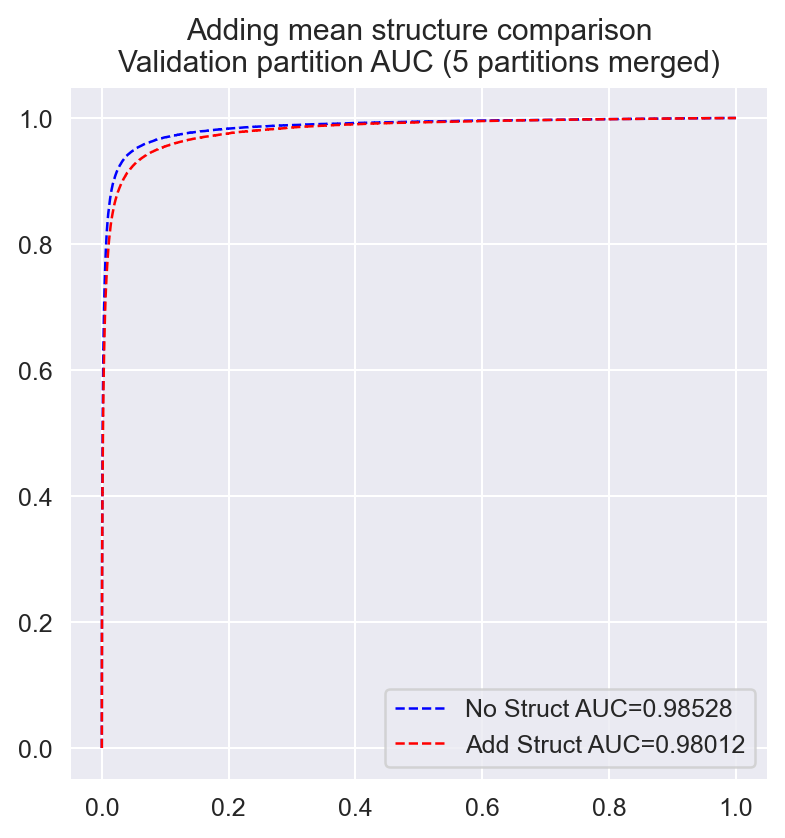

In [48]:
f,a = plt.subplots(1,1, figsize=(5,5))
fpr, tpr, _ = roc_curve(no_struct['target'], no_struct['pred'])
auc = roc_auc_score(no_struct['target'], no_struct['pred'])
a.plot(fpr, tpr, c='b', lw=1, ls='--', label=f'No Struct AUC={auc:.5f}')
fpr, tpr, _ = roc_curve(add_struct['target'], add_struct['pred'])
auc = roc_auc_score(add_struct['target'], add_struct['pred'])
a.plot(fpr, tpr, c='r', lw=1, ls='--', label=f'Add Struct AUC={auc:.5f}')
a.legend()
a.set_title('Adding mean structure comparison\nValidation partition AUC (5 partitions merged)')

# investigating

In [26]:
no = pd.concat([pd.read_csv(x) for x in glob.glob('../output/MeanStructureEval/*False*/*valid*.csv')])
add = pd.concat([pd.read_csv(x) for x in glob.glob('../output/MeanStructureEval/*True*/*valid*.csv')])

In [29]:
no.columns

Index(['sequence', 'target', 'HLA', 'context', 'fold', 'pseudoseq',
       'protein_id', 'start_position', 'end_position', 'rsa', 'pq3_H', 'pq3_E',
       'pq3_C', 'disorder', 'len', 'pred', 'core_start_index', 'label',
       'motif'],
      dtype='object')

In [31]:
def get_mean_struct(df, col):
    df[f'mean_{col}'] = df[col].apply(lambda x: np.mean([float(z) for z in x.split(',')]))
    return df.drop(columns=[col])

def do_all_struct(df, cols):
    for c in cols:
        df = get_mean_struct(df, c)
    return df

no = do_all_struct(no, ['disorder', 'rsa', 'pq3_H', 'pq3_C', 'pq3_E'])
add = do_all_struct(add, ['disorder', 'rsa', 'pq3_H', 'pq3_C', 'pq3_E'])

In [33]:
mcs = [f'mean_{x}' for x in ['disorder', 'rsa', 'pq3_H', 'pq3_C', 'pq3_E']]
display(no.groupby('label')[mcs].mean())
display(add.groupby('label')[mcs].mean())

,mean_disorder,mean_rsa,mean_pq3_H,mean_pq3_C,mean_pq3_E
label,,,,,
0.0,0.257049,0.397907,0.321265,0.547998,0.130737
1.0,0.182880,0.358594,0.390294,0.466388,0.143319


,mean_disorder,mean_rsa,mean_pq3_H,mean_pq3_C,mean_pq3_E
label,,,,,
0.0,0.257049,0.397907,0.321265,0.547998,0.130737
1.0,0.182880,0.358594,0.390294,0.466388,0.143319


In [68]:
corr

,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_C,mean_pq3_E
mean_rsa,1.000000,0.871292,-0.433379,0.737164,-0.213886
mean_disorder,0.871292,1.000000,-0.433125,0.763985,-0.188626
mean_pq3_H,-0.433379,-0.433125,1.000000,-0.733346,-0.514179
mean_pq3_C,0.737164,0.763985,-0.733346,1.000000,0.124389
mean_pq3_E,-0.213886,-0.188626,-0.514179,0.124389,1.000000


<Axes: >

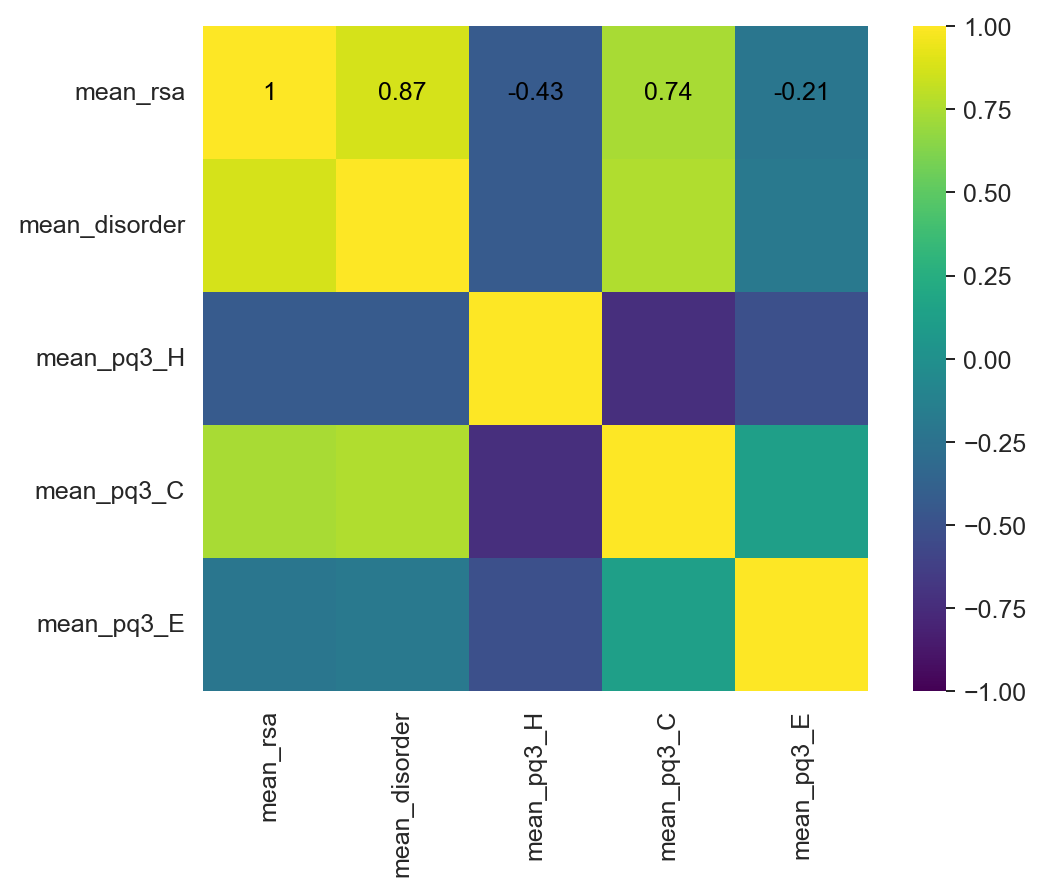

In [67]:
corr=no[['mean_rsa','mean_disorder','mean_pq3_H','mean_pq3_C','mean_pq3_E']].corr('spearman')
sns.heatmap(corr, square=True, cmap='viridis', vmin=-1, vmax=1, center=0, annot=corr.values, annot_kws={'c':'k'})

In [34]:
neg = add.query('label!=1')
pos = add.query('label==1')

In [44]:
from scipy.stats import ttest_ind

print('mean_disorder', ttest_ind(neg['mean_disorder'], pos['mean_disorder'], alternative='greater').pvalue)
print('mean_rsa', ttest_ind(neg['mean_rsa'], pos['mean_rsa'], alternative='greater').pvalue)
print('mean_pq3_H', ttest_ind(neg['mean_pq3_H'], pos['mean_pq3_H'], alternative='less').pvalue)
print('mean_pq3_E', ttest_ind(neg['mean_pq3_E'], pos['mean_pq3_E'], alternative='less').pvalue)
print('mean_pq3_C', ttest_ind(neg['mean_pq3_C'], pos['mean_pq3_C'], alternative='greater').pvalue)

mean_disorder 0.0
mean_rsa 0.0
mean_pq3_H 0.0
mean_pq3_E 7.532602681037607e-47
mean_pq3_C 0.0


In [49]:
no['indel'] = no['motif'].str.contains('-')
add['indel'] = add['motif'].str.contains('-')

In [54]:
add.groupby(['label', 'indel'])['pred'].describe()

count      mean       std           min       25%       50%  \
label indel                                                                   
0.0   False  785218.0  0.017286  0.084180  4.017446e-18  0.000002  0.000063   
      True   155027.0  0.009498  0.055150  7.312477e-15  0.000001  0.000032   
1.0   False   55974.0  0.737488  0.314259  9.851879e-12  0.585656  0.891502   
      True     3781.0  0.513023  0.361110  2.534919e-09  0.122750  0.579174   

                  75%       max  
label indel                      
0.0   False  0.001440  0.999892  
      True   0.000681  0.988001  
1.0   False  0.975825  0.999995  
      True   0.860337  0.998634

In [73]:
class Test(nn.Module):
    def __init__(self):
        super(Test, self).__init__()
        self.in_layer = nn.Linear(50,30)
        self.out_layer = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.25)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.get_logits(x)
        x = F.sigmoid(x)
        return x

    def get_logits(self, x):
        x = self.in_layer(x)
        x = self.dropout(x)
        x = self.act(x)
        x = self.out_layer(x)
        return x

In [80]:
mod.train()
z = mod.get_logits(x)[:25]
mod.eval()
z2 = mod.get_logits(x)[:25]

In [86]:
mod = Test()
x = torch.rand(10, 50)
y = torch.randint(0, high=2, size=(1000,))

mod.train()
print(mod(x), mod.get_logits(x))

mod.eval()
print(mod(x), mod.get_logits(x))

tensor([[0.4641],
        [0.4704],
        [0.4483],
        [0.4499],
        [0.4759],
        [0.4591],
        [0.4996],
        [0.4433],
        [0.4412],
        [0.4816]], grad_fn=<SigmoidBackward0>) tensor([[-0.0336],
        [-0.1895],
        [-0.2251],
        [-0.1660],
        [-0.1974],
        [-0.1506],
        [-0.0536],
        [-0.0516],
        [-0.1115],
        [-0.1198]], grad_fn=<AddmmBackward0>)
tensor([[0.4661],
        [0.4622],
        [0.4516],
        [0.4692],
        [0.4732],
        [0.4643],
        [0.4865],
        [0.4689],
        [0.4737],
        [0.4799]], grad_fn=<SigmoidBackward0>) tensor([[-0.1359],
        [-0.1517],
        [-0.1942],
        [-0.1235],
        [-0.1072],
        [-0.1429],
        [-0.0539],
        [-0.1244],
        [-0.1052],
        [-0.0806]], grad_fn=<AddmmBackward0>)
